In [11]:
import pickle
import random
from os.path import join
from copy import deepcopy, copy
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy import interp
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve

from indra.tools import assemble_corpus as ac
from indra.belief.skl import CountsScorer
from bioexp.util import format_axis, fontsize
from bioexp.curation.belief_models import OrigBeliefStmt
from bioexp.curation.classifiers import BinaryRandomForest, LogLogisticRegression, BeliefModel

from bioexp.curation.process_curations import get_full_curations, get_raw_curations, reader_input
%matplotlib notebook

In [12]:
# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2021-05-14 11:47:53] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2021-05-14 11:49:51] indra.tools.assemble_corpus - Loaded 895580 statements


Make a dictionary so we can retrieve statements by their hash, and define some other useful variables:

In [13]:
stmts_by_hash = {s.get_hash(): s for s in all_stmts}

reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']

opath = '../output/'
prefix = 'fig4_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

Load the curated data:

In [14]:
#curation_data_file = join(opath, 'curation_dataset_with_bg_psp.pkl')
#curation_data_file = join(opath, 'curation_dataset.pkl')
curation_data_file = join(opath, 'curation_dataset_inc.pkl')

def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

cur_df = load_curation_data(curation_data_file)

How many records in the dataset?

In [15]:
cur_df.shape

(1330, 30)

Get a list of all the curated statements:

In [16]:
# Get dataset of curated statements along with correctness values
def stmts_for_df(df, stmts_by_hash):
    stmt_list = []
    for row in df.itertuples():
        stmt_hash = row.stmt_hash
        stmt_list.append(stmts_by_hash[stmt_hash])
    return stmt_list

cur_stmts = stmts_for_df(cur_df, stmts_by_hash)

List all the source APIs for curated statements:

In [17]:
all_sources = list(set([ev.source_api for stmt in cur_stmts for ev in stmt.evidence]))
all_sources

['trips',
 'hprd',
 'rlimsp',
 'sparser',
 'bel',
 'biopax',
 'trrust',
 'isi',
 'medscan',
 'signor',
 'reach']

Define classes for storing the results of training and testing models. `TrainTestResult` Records the predictions, probabilities, RO curve, PR curve, etc. for a single fold of the data. `ModelResult` aggregates the `TrainTestResult` objects for all of the folds.

In [18]:
class TrainTestResult:
    def __init__(self, y_preds, y_probs, y_test, base_fpr):
        self.y_preds = y_preds
        self.y_probs = y_probs      
        self.y_test = y_test
        # Get and store true/false positive rates and thresholds for ROC curve
        self.fpr, self.tpr, self.thresholds = roc_curve(y_test, y_probs[:, 1])
        # Calculate ROC AUC
        self.roc_auc = auc(self.fpr, self.tpr)
        # Get TPR interpolated to base_fpr
        self.tpr_interp = interp(base_fpr, self.fpr, self.tpr)
        self.tpr_interp[0] = 0.0
        # Precision/recall/thresholds for each model
        self.precision, self.recall, self.thresholds = precision_recall_curve(y_test, y_probs[:, 1])
        self.pr_auc = auc(self.recall, self.precision)
        #pr_auc_arr[fold_ix] = pr_auc
        self.prec_interp = interp(base_fpr, self.thresholds, self.precision[:-1])
        #prec_arr[fold_ix, :] = interp(base_fpr, thresholds, precision[:-1])
        self.rec_interp = interp(base_fpr, self.thresholds, self.recall[:-1])

class ModelResults:
    def __init__(self, clf_name, feat_set_name, feat_kwargs, base_fpr):
        # True positives
        self.base_fpr = base_fpr
        self.clf_name = clf_name
        self.feat_set_name = feat_set_name
        self.feat_kwargs = feat_kwargs
        self.tt_results = []
        
    def add_result(self, tt_result):
        self.tt_results.append(tt_result)

    def get_summary(self):
        clf_results = [{'y_preds': tt.y_preds,
                        'y_probs': tt.y_probs,
                        'y_test': tt.y_test} for tt in self.tt_results]
        # Combine get matrices with all TPR, Precision and Recall results
        dim = (len(self.tt_results), len(self.base_fpr))
        tpr_arr = np.zeros(dim)
        prec_arr = np.zeros(dim)
        rec_arr = np.zeros(dim)
        for ix, ttr in enumerate(self.tt_results):
            tpr_arr[ix, :] = ttr.tpr_interp
            prec_arr[ix, :] = ttr.prec_interp
            rec_arr[ix, :] = ttr.rec_interp
        return {
         'clf': clf_results,
         'roc': tpr_arr.mean(axis=0),
         'roc_auc': np.array([ttr.roc_auc for ttr in self.tt_results]),
         'prec': prec_arr.mean(axis=0),
         'rec': rec_arr.mean(axis=0),
         'pr_auc': np.array([ttr.pr_auc for ttr in self.tt_results]),
         'x_interp': self.base_fpr}

In [22]:
def shuffle_train_df(df, stmts_by_hash, seed=1):
    """Given dataframe, return shuffled stmts and y_arr."""
    stmts = stmts_for_df(df, stmts_by_hash)
    y_arr = df['correct'].values
    return shuffle_train_stmts(stmts, y_arr, seed)

def shuffle_train_stmts(stmts, y_arr, seed=1):
    """Return training data as a shuffled list of statements
    and corresponding correctness values."""
    random.seed(seed)
    stmt_y_pairs = list(zip(stmts, y_arr))
    random.shuffle(stmt_y_pairs)
    stmts, y_vals = list(zip(*stmt_y_pairs))
    return stmts, np.array(y_vals)    

# DEPRECATED. Use StratifiedKFold
def get_split_points(size, num_folds):
    """Generates size/p pairs of split indices for separating an array of the given
    size into chunks with percentage p. For example for a list of size 100 with
    p = 0.2, returns ((0, 20), (20, 40), (40, 60), (60, 80), and (80, 100))
    """
    # rsp: Raw split points
    rsp = np.linspace(0, size, num_folds)
    split_indices = [(int(round(rsp[i])), int(round(rsp[i+1])))
                     for i in range(len(rsp)-1)]
    return split_indices


Given a dictionary of models and a dataset, this function:
* Filters the dataset columns to only the given readers, and filters the rows to only those where there is evidence from those readers (i.e., so all databases are excluded)
* Defines a set of different statement features to use
* Splits the dataset into test and train using StratifiedKFold
* Trains and tests all models, for all feature sets, for all folds

In [29]:
# Train and evaluate a set of models
def eval_models_relation(model_dict, df, readers, split_func, num_folds=10,
                         cols_to_include=None, seed=1):
    # Filter to columns where at least one of the readers has an entry
    # Exclude
    cols_to_drop = [col for col in df.columns if col not in readers + ['stmt_hash', 'correct']]
    df = df.drop(cols_to_drop, axis=1)
    df = df[df[readers].any(1)]
    print("Readers", str(readers), "Num_rows", len(df), "Pct corr", df['correct'].mean())
    # Predictors
    predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
                  #'+ Type': {'use_stmt_type': True, 'use_num_members': False}, 
                  #'+ #Memb': {'use_stmt_type': False, 'use_num_members': True},
                  #'+ Type/#Memb': {'use_stmt_type': True, 'use_num_members': True},
                  #'+ #PMIDs': {'use_stmt_type': False, 'use_num_pmids': True},
                  #'+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},                  
                  #'Only KGE': x[:, -1:]} # Only the score column
                 }
    # The baseline y-axis for ROC and PRC plots
    base_fpr = np.linspace(0, 1, 101)    
    # Shuffle the data
    stmts, y_arr = shuffle_train_df(df, stmts_by_hash, seed=seed)
    # Get split points
    #split_indices = get_split_points(len(df), num_folds)
    skf = StratifiedKFold(num_folds, shuffle=False)
    skf.split(stmts, y_arr)
    # Dict to save results
    model_results = {}    
    # For every fold...
    for fold_ix, (train_ix, test_ix) in tqdm(enumerate(skf.split(stmts, y_arr))):
        # ...try every classifier
        for clf_name, clf in model_dict.items():
            # ...with different sets of features (predictors):
            for feat_set_name, feat_kwargs in predictors.items():
                # Create a CountsModel for this type of classifier
                model = CountsScorer(clf, readers, **feat_kwargs)
                #model = EvidenceModel(clf) 
                # Identifier for this model type
                model_key = '%s %s' % (clf_name, feat_set_name)
                # If necessary, instantiate the ModelResults object to
                # save train/test results
                if model_key not in model_results:
                    model_results[model_key] = ModelResults(clf_name, feat_set_name, feat_kwargs, base_fpr)
                # Use instance of CountsModel to get feature data as a matrix
                # with appropriate featurization
                stmt_arr = model.to_matrix(stmts)
                # Split the preprocessed data matrix according to the split points
                x_test = stmt_arr[test_ix]
                x_train = stmt_arr[train_ix]
                y_test = y_arr[test_ix]
                y_train = y_arr[train_ix]
                # Train the model
                clf.fit(x_train, y_train)
                # Make predictions for the test set
                y_preds = clf.predict(x_test)
                y_probs = clf.predict_proba(x_test)
                # Save results in TrainTestResult object
                tt_result = TrainTestResult(y_preds, y_probs, y_test, base_fpr)
                # Add to the model results for this model type
                model_results[model_key].add_result(tt_result)
    return model_results

Functions to plot ROC and PRC curves, averaged across folds:

In [43]:
# Functions to plot mean ROC and AUPRC from k-fold cross-validation

def plot_roc(results):
    fig = plt.figure(figsize=(2.0, 2.0), dpi=150)
    ax = plt.gca()
    lw = 0.5
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    colors = colors + colors
    # Plot ROC curve for Belief Model (REACH)
    #plt.plot(bel_fpr, bel_tpr, color=colors[0],
    #         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
    #roc_results = results['roc']
    #roc_auc = results['roc_auc']
    for i, (clf_name, mr_obj) in enumerate(results.items()):
        mr_dict = mr_obj.get_summary()
        roc_auc_arr = mr_dict['roc_auc']
        plt.plot(mr_dict['x_interp'], mr_dict['roc'], color=colors[i],
             lw=lw, label='%s (area = %0.3f +/- %0.3f)' %
                          (clf_name, roc_auc_arr.mean(), roc_auc_arr.std() / np.sqrt(len(roc_auc_arr))))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic', fontsize=6)
    plt.legend(loc="lower right", fontsize=5, frameon=False)
    format_axis(ax)
    
    plt.subplots_adjust(left=0.15)
    return fig

# Function to plot mean precision-recall curve from k-fold cross validation
def plot_prc(results):
    fig = plt.figure(figsize=(2.0, 2.0), dpi=150)
    ax = plt.gca()
    lw = 0.5
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    colors = colors + colors
    for i, (clf_name, mr_obj) in enumerate(results.items()):
        mr_dict = mr_obj.get_summary()
        prec_arr = mr_dict['prec']
        rec_arr = mr_dict['rec']
        pr_auc = mr_dict['pr_auc']                                   
        plt.plot(rec_arr, prec_arr, color=colors[i],
             lw=lw, label='%s (area = %0.3f +/- %0.3f)' %
                          (clf_name, pr_auc.mean(), pr_auc.std() / np.sqrt(len(pr_auc))))
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    fontsize=6
    plt.title('Precision-Recall Curve', fontsize=6)
    plt.legend(loc="lower left", fontsize=5, frameon=False)
    format_axis(ax)
    return fig

## Analyze 

In [38]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    #'LR': LogisticRegression(),
    'Log LR': LogLogisticRegression(),    
    #'RF d5': RandomForestClassifier(n_estimators=1000, max_depth=6),
    #'RF d6': RandomForestClassifier(n_estimators=1000, max_depth=7),
    #'Random Forest': RandomForestClassifier(),
    #'Binary RF n1000d4': BinaryRandomForest(n_estimators=1000, max_depth=4),
    #'Binary RF': BinaryRandomForest(),
    #'Binary RF n1000': BinaryRandomForest(n_estimators=1000)
    #'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

In [39]:
reader_list = ['rlimsp', 'trips', 'sparser']
res_ev = eval_models_relation(models_ev, cur_df, reader_list, None,
                              num_folds=10, cols_to_include=None, seed=1)

#res_ev = eval_models_relation(models_ev, ev_stmts, reader_list, train_test_split,
#                              num_folds=10, cols_to_include=None, seed=2)

0it [00:00, ?it/s]INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
3it [00:00, 23.33it/s]INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.


Readers ['rlimsp', 'trips', 'sparser'] Num_rows 897 Pct corr 0.8372352285395763


INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
6it [00:00, 23.40it/s]INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
9it [00:00, 23.50it/s]INFO: [2021-05-14 12:46:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
10it [00:00, 23.46it/s]


In [47]:
reach_fits = eval_models_relation(models_ev, cur_df, ['reach'], None,
                              num_folds=10, cols_to_include=None, seed=1)
sparser_fits = eval_models_relation(models_ev, cur_df, ['sparser'], None,
                              num_folds=10, cols_to_include=None, seed=1)
reach_sparser_fits = eval_models_relation(models_ev, cur_df, ['reach', 'sparser'], None,
                              num_folds=10, cols_to_include=None, seed=1)


0it [00:00, ?it/s]INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
3it [00:00, 23.84it/s]INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.


Readers ['reach'] Num_rows 954 Pct corr 0.8092243186582809


INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
6it [00:00, 23.86it/s]INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
9it [00:00, 23.87it/s]INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
10it [00:00, 23.83it/s]
0it [00:00, ?it/s]INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement 

Readers ['sparser'] Num_rows 695 Pct corr 0.8633093525179856


INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
6it [00:00, 25.60it/s]INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
9it [00:00, 25.70it/s]INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
10it [00:00, 25.76it/s]
0it [00:00, ?it/s]INFO: [2021-05-14 12:52:21] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:22] indra.belief.skl - source_list does not include all source_apis in the statement 

Readers ['reach', 'sparser'] Num_rows 1078 Pct corr 0.7922077922077922


INFO: [2021-05-14 12:52:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
6it [00:00, 22.11it/s]INFO: [2021-05-14 12:52:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 12:52:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
9it [00:00, 21.99it/s]INFO: [2021-05-14 12:52:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
10it [00:00, 21.95it/s]


<IPython.core.display.Javascript object>


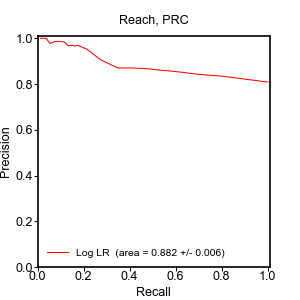

Text(0.5, 1.0, 'Reach, PRC')

In [66]:
#fig = plot_roc(reach_fits)
fig = plot_prc(reach_fits)
ax = fig.gca()
#ax.set_title('Reach, ROC', fontsize=6)
ax.set_title('Reach, PRC', fontsize=6)

<IPython.core.display.Javascript object>


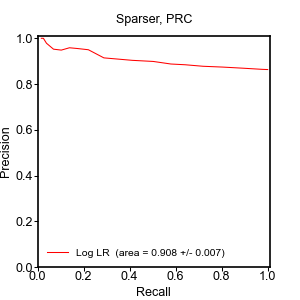

Text(0.5, 1.0, 'Sparser, PRC')

In [67]:
#fig = plot_roc(sparser_fits)
fig = plot_prc(sparser_fits)
ax = fig.gca()
#ax.set_title('Sparser, ROC', fontsize=6)
ax.set_title('Sparser, PRC', fontsize=6)

<IPython.core.display.Javascript object>


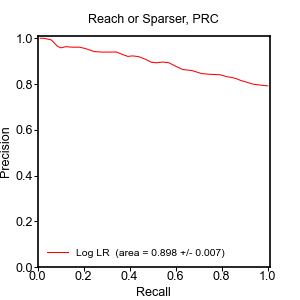

Text(0.5, 1.0, 'Reach or Sparser, PRC')

In [68]:
#fig = plot_roc(reach_sparser_fits)
fig = plot_prc(reach_sparser_fits)
ax = fig.gca()
#ax.set_title('Reach or Sparser, ROC', fontsize=6)
ax.set_title('Reach or Sparser, PRC', fontsize=6)

<IPython.core.display.Javascript object>


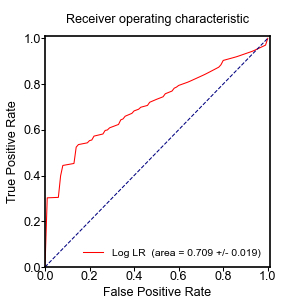

In [59]:
fig = plot_roc(res_ev)

In [ ]:
fig = plot_prc(res_ev)

We note that the performance of all classifiers increases with the number of readers used. We measured AUROC and AUPRC of each classifier starting with data from 1 reader and increasing to 5 and not surprisingly found that both increased with additional readers. It is important to note though that this analysis was performed using the unweighted curation dataset which is biased towards high-mention statements with a higher likelihood of reader overlap.

In [77]:
def plot_aurocs(clf_aurocs, xticks, xticklabels, title, xlabel):
    fig = plt.figure(figsize=(2.5, 2), dpi=150)
    for clf_name, aurocs in clf_aurocs.items():
        plt.errorbar(xticks, aurocs['mean'], yerr=aurocs['se'], label=clf_name, marker='.',
                     lw=0.5)
    plt.legend(loc="lower right", frameon=False, fontsize=6)
    plt.ylabel('AUROC')
    #plt.title(title)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    ax = plt.gca()
    ax.set_xticklabels(xticklabels)
    plt.subplots_adjust(left=0.18, right=0.95)
    format_axis(ax)
    return fig

def plot_auprcs(clf_auprcs, xticks, xticklabels, title, xlabel):
    fig = plt.figure(figsize=(2.5, 2), dpi=150)
    for clf_name, auprcs in clf_auprcs.items():
        plt.errorbar(xticks, auprcs['mean'], yerr=auprcs['se'], label=clf_name, marker='.',
                     lw=0.5)
    plt.legend(loc="lower right", frameon=False, fontsize=6)
    plt.ylabel('AUPRC')
    #plt.title(title)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    plt.ylim([0.75, 1.0])
    ax = plt.gca()
    ax.set_xticklabels(xticklabels)
    plt.subplots_adjust(left=0.18, right=0.95)
    format_axis(ax)
    return fig

In [78]:
def adding_readers(reader_list, df, num_folds=10):
    clf_aurocs = {}
    clf_auprcs = {}
    for i in range(1, len(reader_list) + 1):
        reader_subset = reader_list[0:i]
        #cols_to_drop = [col for col in df.columns if col not in reader_subset + ['correct']]
        #readers_to_drop = reader_list[i:]
        #train_df = df.drop(cols_to_drop, axis=1)
        #train_df = train_df[train_df[reader_subset].any(1)]
        #print(f"Readers: {reader_subset}; num_rows: {len(df)}; correct: {train_df.correct.mean()}")
        models_ev = {
            #'Logistic Regression': LogisticRegression(),
            'Log-Logistic Regression': LogLogisticRegression(),    
            #'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=6),
            #'Random Forest': RandomForestClassifier(),
            #'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
            #'Binary Random Forest': BinaryRandomForest(),
            #'Belief': BeliefModel(reader_subset),
            #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
            #                           nwalkers=100, burn_steps=100, sample_steps=100)
            #'GaussianNB': GaussianNB(),
        }
                
        res_ev = eval_models_relation(models_ev, df, reader_subset, None,
                                      num_folds=num_folds)
        for i, (clf_name, clf_res) in enumerate(res_ev.items()):
            clf_summary = clf_res.get_summary()
            roc_auc_arr = clf_summary['roc_auc']
            pr_auc_arr = clf_summary['pr_auc']
            if clf_name not in clf_aurocs:
                clf_aurocs[clf_name] = {'mean': [], 'se': []}                
            clf_aurocs[clf_name]['mean'].append(roc_auc_arr.mean())
            clf_aurocs[clf_name]['se'].append(roc_auc_arr.std() / np.sqrt(len(roc_auc_arr)))
            if clf_name not in clf_auprcs:
                clf_auprcs[clf_name] = {'mean': [], 'se': []}
            clf_auprcs[clf_name]['mean'].append(pr_auc_arr.mean())
            clf_auprcs[clf_name]['se'].append(pr_auc_arr.std())
    return (clf_aurocs, clf_auprcs)

Adding readers:

In [97]:
#reader_list = list(reversed(['reach', 'medscan', 'sparser', 'trips', 'rlimsp'])) #'rlimsp'
reader_list = ['sparser', 'medscan', 'reach']

In [98]:
#ar_aurocs, ar_auprcs = adding_readers(reader_list, kge_df, num_folds=10)
ar_aurocs, ar_auprcs = adding_readers(reader_list, cur_df, num_folds=10)

0it [00:00, ?it/s]INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
3it [00:00, 25.72it/s]INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.


Readers ['sparser'] Num_rows 695 Pct corr 0.8633093525179856


INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
6it [00:00, 25.90it/s]INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
9it [00:00, 26.07it/s]INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
10it [00:00, 26.10it/s]
0it [00:00, ?it/s]INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:33] indra.belief.skl - source_list does not include all source_apis in the statement 

Readers ['sparser', 'medscan'] Num_rows 1012 Pct corr 0.8191699604743083


INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
6it [00:00, 22.84it/s]INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
9it [00:00, 22.89it/s]INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
10it [00:00, 22.84it/s]
0it [00:00, ?it/s]INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement 

Readers ['sparser', 'medscan', 'reach'] Num_rows 1217 Pct corr 0.7748562037797864


INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
6it [00:00, 21.49it/s]INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
9it [00:00, 21.37it/s]INFO: [2021-05-14 13:17:34] indra.belief.skl - source_list does not include all source_apis in the statement data.
10it [00:00, 21.31it/s]


* Readers: ['reach']; num_rows: 1007; correct: 0.8083416087388282
* Readers: ['reach', 'medscan']; num_rows: 1176; correct: 0.7882653061224489
* Readers: ['reach', 'medscan', 'sparser']; num_rows: 1308; correct: 0.7408256880733946
* Readers: ['reach', 'medscan', 'sparser', 'trips']; num_rows: 1370; correct: 0.7372262773722628
* Readers: ['reach', 'medscan', 'sparser', 'trips', 'rlimsp']; num_rows: 1435; correct: 0.7344947735191638

<IPython.core.display.Javascript object>


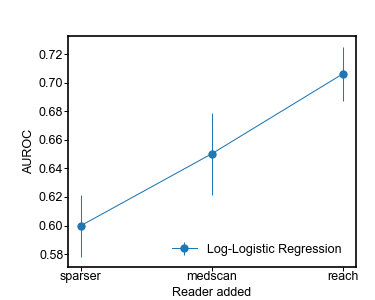

In [99]:
fig = plot_aurocs(ar_aurocs, list(range(len(reader_list))), reader_list,
            'Classifier AUROC with increasing readers', 'Reader added')
fig.savefig(fig_path('auroc_more_readers', 'pdf'))

<IPython.core.display.Javascript object>


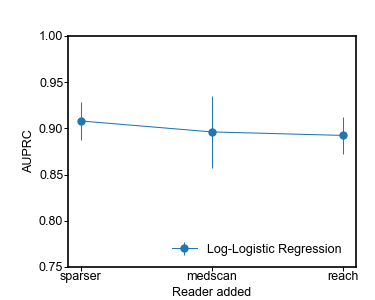

In [100]:
fig = plot_auprcs(ar_auprcs, list(range(len(reader_list))), reader_list,
           'Classifier AUPRC with increasing readers', 'Reader added')
fig.savefig(fig_path('auprc_more_readers', 'pdf'))

In [96]:
def adding_data(num_low_high, reader_list, df, num_folds=10):
    clf_aurocs = {}
    clf_auprcs = {}
    
    for i, (num_low, num_high) in enumerate(num_low_high):
        reader_subset = reader_list[0:i]
        readers_to_drop = reader_list[i:]
        train_df = df.drop(readers_to_drop, axis=1)
        
        def split_closure(x_data, y_data, test_size):
            return split_by_ev_ct(x_data, y_data, reader_list, low_ub=1, num_low=num_low,
                                  high_lb=8, num_high=num_high, test_size=test_size)
        
        models_ev = {
            'Logistic Regression': LogisticRegression(),
            'Log-Logistic Regression': LogLogisticRegression(),    
            #'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
            #'Random Forest': RandomForestClassifier(),
            #'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
            #'Belief': BeliefModel(reader_subset),
            #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
            #                           nwalkers=100, burn_steps=100, sample_steps=100)
            #'GaussianNB': GaussianNB(),
        }
        res_ev = eval_models_relation(models_ev, train_df, reader_list, split_closure,
                                      test_split=0.2, num_folds=num_folds)
        roc_auc = res_ev['roc_auc']
        pr_auc = res_ev['pr_auc']
        for i, (clf_name, roc_auc_arr) in enumerate(roc_auc.items()):
            pr_auc_arr = pr_auc[clf_name]
            if clf_name not in clf_aurocs:
                clf_aurocs[clf_name] = {'mean': [], 'sd': []}
            clf_aurocs[clf_name]['mean'].append(roc_auc_arr.mean())
            clf_aurocs[clf_name]['sd'].append(roc_auc_arr.std())
            if clf_name not in clf_auprcs:
                clf_auprcs[clf_name] = {'mean': [], 'sd': []}
            clf_auprcs[clf_name]['mean'].append(pr_auc_arr.mean())
            clf_auprcs[clf_name]['sd'].append(pr_auc_arr.std())
    return (clf_aurocs, clf_auprcs)

In [ ]:
num_low_high = [(5, 5), (10, 10), (20, 20), (30, 30)]
ad_aurocs, ad_auprcs = adding_data(num_low_high, reader_list, kge_df, num_folds=10)

In [ ]:
stmts_for_df

# Include RGCN Scores

In [ ]:
rgcn_df = pd.read_csv('curated_with_scores.csv', index_col=0)

In [ ]:
rgcn_df.score